## Setup

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from numba import jit, njit
from tqdm.auto import tqdm
from alg.functions import functions
from alg.bits import find_int_number_of_bits, bit_metrics, \
                        bits_to_value, value_to_bits, \
                        bitstring_to_array, array_to_bitstring
from alg.sa import sa, acc_prob_ln, acc_prob_e

from pathlib import Path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

tqdm.pandas()

root = Path('H:\\Data\\nextcloud2')

## Plot configuration

In [2]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.style.use('grayscale')
figsize33 = (17, 10) # (17, 12)
title_fontsize = 30

## Data Loading

In [3]:
from scipy.interpolate import PchipInterpolator

def ind_to_clean_points(ind):
    xs, ys = ind
    xs = np.array([0] + list(xs) + [1])

    xs_to_ys = dict()
    for x, y in zip(xs, ys):
        if x in xs_to_ys.keys():
            xs_to_ys[x].append(y)
        else:
            xs_to_ys[x] = [y]

    new_x = []
    new_y = []
    for x, ys in xs_to_ys.items():
        new_x.append(x)
        new_y.append(np.mean(ys))

    xs = np.array(new_x)
    ys = np.array(new_y)

    ys = ys[np.argsort(xs)]
    xs = xs[np.argsort(xs)]
    return xs, ys

def dense_from_ind(ind):
    xs, ys = ind_to_clean_points(ind)
    pchip = PchipInterpolator(xs, ys)
    xnew = np.linspace(0, 1, num=1000 + 1)
    ynew = pchip(xnew)
    return xnew, ynew

In [4]:
def load_exp1_results(root):
    exp1_root = os.path.join('experiments', 'experiment_1_ln_vs_exp')
    ln_root = os.path.join(exp1_root, f'ln_best')
    
    results = []
    for run_path in os.listdir(ln_root):
        results.append(pd.read_parquet(os.path.join(ln_root, run_path)))
    
    return pd.concat(results).drop(columns=['apf_param', 'p_max'])

old_ln = load_exp1_results('experiments')
old_ln['iter_factor'] = 500
old_ln['APF'] = 'monotonic_ln'
old_ln['p'] = 0

In [5]:
name_to_func = {f.name:f for f in functions}

plots_folder = Path('plots') / 'ga_and_nsgaiii'
plots_folder.mkdir(exist_ok=True, parents=True)

In [6]:
def eval_ind(fname, best_x, best_y, d=2, iter_factor=500):
    xs, ys = ind_to_clean_points((best_x, best_y))
    xnew, ynew = dense_from_ind((best_x, best_y))

    def generated_apf(_score, _n_score, T0, _k, max_iter, min_score, max_score, t, p_max):
        moment = (_k + 1) / max_iter
        x = (_n_score - _score) / (max_score - min_score) * (1 - moment) + moment
        return ynew[round(x * (len(ynew) - 1))]

    target_function = name_to_func[fname]
    max_iter = iter_factor * (d ** 2)

    sa_scores, accept_probs, outcomes = sa(target_function=target_function.f,
       lb=target_function.lb, ub=target_function.ub,
       acc_prob_=generated_apf, T0=-1000, apf_param=-1000, p_max=-1000,
       n_dims=d, max_iter=max_iter)
    return np.min(sa_scores)

In [40]:
interesting_functions = ['Rosenbrock', 'Rastrigin', 'Griewangk', 'Schwefel', 'Eggholder', 'Rana']

folder = 'prod'
tfk_to_pts = list()
for worker_folder in root.glob('aiworker*'):
    exp = worker_folder / 'experiments' / folder
    for e in exp.glob('*'):
        _, tf, k = e.stem.split('_')
        tf = tf.split('=')[1]
        k = int(k.split('=')[1])
        xy = np.load(e / 'last_x.npy')
        scores = np.load(e / 'last_y.npy')
        tfk_to_pts.append((tf, k, xy[:, :k], xy[:, k:], scores))

mo_results_path = f'mo_ub_results_{folder}_v2.parquet'
try:
    assert False
    df = pd.read_parquet(mo_results_path)
except:
    d = 2
    iter_factor = 500
    data = []

    for (fname, k, x, y, scores) in tqdm(tfk_to_pts):
        for i in range(x.shape[0]):
            best_x = x[i]
            best_y = y[i]
            # todo: evaluation should be done on the test functions
            for test_function in interesting_functions:
                if fname != test_function:
                    min_scores = []
                    for _ in range(30):
                        min_score = eval_ind(test_function, best_x, best_y, 
                                             d=d, iter_factor=iter_factor)
                        min_scores.append(min_score)
                    min_score = np.median(min_scores)
                    data.append({
                        'target':fname,
                        'test_target':test_function,
                        'p':k,
                        'ind_index':i,
                        'min_score':min_score,
                    })

    df = pd.DataFrame(data)
    df['APF'] = 'NGSAIII'
    df.to_parquet(mo_results_path)

  0%|          | 0/24 [00:00<?, ?it/s]

For each target:
- identifier by [p, ind_index]. Normalize by test_target -> mean score per identifier.

In [83]:
mo_best_pts = dict()

for target in df.target.unique():
    _mo = df.query('target==@target').copy()
    vmax = _mo.groupby('test_target').min_score.max()
    vmin = _mo.groupby('test_target').min_score.min()
    normalized = _mo.apply(lambda row: (row.min_score - vmin[row.test_target]) / \
          (vmax[row.test_target] - vmin[row.test_target]), axis=1)
    _mo['norm_min_score'] = normalized
    best_p, best_ind_index = _mo.groupby(['p', 'ind_index']).norm_min_score\
                            .mean().sort_values().index[0]
    for (fname, k, x, y, scores) in tfk_to_pts:
        if fname == target and k == best_p:
            best_x = x[best_ind_index]
            best_y = y[best_ind_index]
            mo_best_pts[target] = (best_x, best_y)

In [86]:
mo_data = list()
for fname, (best_x, best_y) in tqdm(mo_best_pts.items()):
    for _ in range(30):
        min_score = eval_ind(fname, best_x, best_y, d=2, iter_factor=500)
        mo_data.append({
            'target':fname,
            'min_score':min_score
        })
mo = pd.DataFrame(mo_data)

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
# nn = 5
# mo_population = dict()
# mo_best = dict()
# for fname, k, x, y, scores in mo_pts:
#     key = (fname, k)
#     if key not in mo_population.keys():
#         mo_population[key] = list()
#     for best_x, best_y in zip(x, y):
#         mo_population[key].append((best_x, best_y))

#     best_index = np.argmin(np.argsort(np.argsort(scores, axis=0), axis=0).mean(axis=1))
#     best_x = x[best_index]
#     best_y = y[best_index]
#     best_score = scores[best_index]

#     if fname not in mo_best.keys():
#         mo_best[fname] = list()
#     mo_best[fname].append((best_x, best_y, best_score))

# mo_best_pts = dict()
# for fname, fdata in mo_best.items():
#     scores = np.zeros((len(fdata), nn), dtype=np.float64)
#     for i, (best_x, best_y, score) in enumerate(fdata):
#         scores[i] = score
#     best_index = np.argmin(np.argsort(np.argsort(scores, axis=0), axis=0).mean(axis=1))
#     best_x, best_y, best_score = fdata[best_index]
#     mo_best_pts[fname] = (best_x, best_y)

# mo_scores = list()
# for fname, (best_x, best_y) in tqdm(mo_best_pts.items()):
#     for _ in range(30):
#         mo_scores.append({
#             'target':fname,
#             'min_score':eval_ind(fname, best_x, best_y)
#         })
# mo = pd.DataFrame(mo_scores)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
def load_ga_results():
    todo_list = list()
    ga_root = Path('C:\\Users\\dinus\\PycharmProjects\\fixed-budget-simulated-annealing\\checkpoints')
    for exp in list(ga_root.glob('*')):
        history_path = exp / 'history.csv'
        if history_path.exists():
            fname, d, iter_factor, p = exp.stem.split('_')
            d = int(d.split('=')[1])
            iter_factor = int(iter_factor.split('=')[1])
            p = int(p.split('=')[1])
            history = pd.read_csv(history_path)
            a = history[history.min_score==history.min_score.min()]
            a = a[a.mean_score==a.mean_score.min()]
            a = a[a.max_score==a.max_score.min()]
            best_generation = a.generation.values[0]
            best_generation_folder = exp / f'generation={best_generation}'
            best_x = np.load(best_generation_folder / 'best_x.npy')
            best_y = np.load(best_generation_folder / 'best_y.npy')
            todo_list.append((fname, d, iter_factor, p, best_x, best_y))
            
    ga_results_path = 'ga30_results.parquet'
    try:
        df = pd.read_parquet(ga_results_path)
    except Exception as e:
        data = []
        
        for fname, d, iter_factor, p, best_x, best_y in tqdm(todo_list):
            for _ in range(30):
                min_score = eval_ind(fname, best_x, best_y, d=d, iter_factor=iter_factor)

                data.append({
                    'target':fname,
                    'n_dims':d,
                    'iter_factor':iter_factor,
                    'p':p,
                    'min_score':min_score
                })

        df = pd.DataFrame(data)
        df['APF'] = 'GA'
    return df, todo_list

ga, ga_pts = load_ga_results()

In [10]:
ga_candidates = dict()
for fname, d, iter_factor, k, best_x, best_y in ga_pts:
    if fname not in ga_candidates.keys():
        ga_candidates[fname] = list()
    ga_candidates[fname].append((best_x, best_y))
    
ga_best_pts = dict()
ga_scores = list()
for fname, candidates in tqdm(ga_candidates.items()):
    scores = np.zeros(len(candidates), dtype=np.float64)
    for i, (best_x, best_y) in enumerate(candidates):
        _scores = []
        for _ in range(30):
            _scores.append(eval_ind(fname, best_x, best_y))
        scores[i] = np.median(_scores)
    
    best_index = np.argmin(scores)
    best_x, best_y = candidates[best_index]
    
    ga_best_pts[fname] = best_x, best_y
    
    for _ in range(30):
        ga_scores.append({
            'target':fname,
            'min_score':eval_ind(fname, best_x, best_y)
        })
ga = pd.DataFrame(ga_scores)

  0%|          | 0/9 [00:00<?, ?it/s]

todo:
- [x] evaluate 30 times the ga best from each row over the ones from the same row (-> similar func; or maybe take the ga bests from the middle column) (label: test-similar-func)
- [ ] evaluate 30 time the mo best (label: test-mo-best) (at each k or only one k?; start with each k)
- plot 3x3 for each function the best ga plot (done). Eval 30 times each (label: train-ga-best)
- in boxplot put labels above and label:log -> 3x2 boxplots

In [11]:
# data = []
# target_to_bestp = dict()
# for target in ga.target.unique():
#     tmp = ga.query('target==@target')
#     if tmp.p.nunique() > 1:
#         best_p = tmp.query('p!=0').groupby('p').min_score.apply(np.median).idxmin()
#         target_to_bestp[target] = best_p
#         _fdf = tmp.query('p==0 or p==@best_p').drop(columns=['p', 'min_score'])
#         data.append(_fdf)
# ga_bestk = pd.concat(data)

# ga_single_best = dict()
# for fname, k in target_to_bestp.items():
#     tmp = ga_best[(fname, k)]
#     assert len(tmp) == 1
#     best_x, best_y = tmp[0]
#     ga_single_best[fname] = best_x, best_y

In [12]:
# mo_best_pts.keys()
# nsga_ub_best_pts.keys()
# ga_best_pts.keys()
    
# ga_best_pts.update(nsga_ub_best_pts)

In [13]:
# ga_test = list()
# for index, func in tqdm(enumerate(functions), total=len(functions)):
#     row = index // 3
#     column = index % 3
#     train_func_index = row * 3 + 1
#     train_fname = functions[train_func_index].name
#     best_x, best_y = ga_best_pts[train_fname]
#     if column != 1:
#         for _ in range(30):
#             min_score = eval_ind(func.name, best_x, best_y)
#             ga_test.append({
#                 'target':func.name,
#                 'min_score':min_score
#             })
# ga_test = pd.DataFrame(ga_test)

In [14]:
ga_test = list()
for index, func in tqdm(enumerate(functions), total=len(functions)):
    row = index // 3
    column = index % 3
    
    for train_func_col in range(3):
        if train_func_col != column:
            train_func_index = row * 3 + train_func_col
            train_fname = functions[train_func_index].name
            best_x, best_y = ga_best_pts[train_fname]

            for _ in range(30):
                min_score = eval_ind(func.name, best_x, best_y)
                ga_test.append({
                    'target':func.name,
                    'min_score':min_score,
                    'APF':'test' + {0:'L', 1:'C', 2:'R'}[train_func_col]
                })
ga_test = pd.DataFrame(ga_test)

  0%|          | 0/9 [00:00<?, ?it/s]

In [89]:
ga['APF'] = 'ga'

mo['APF'] = 'nsgaiii'

In [16]:
old_ln = old_ln.query('n_dims==2').drop(columns=['p', 'n_dims', 'iter_factor'])
old_ln['APF'] = 'log'

In [90]:
df = pd.concat([old_ln, ga, mo, ga_test])

In [91]:
df

,target,min_score,APF
18,Sphere,4.768381e-11,log
37,Bohachevsky,4.254970e-10,log
56,Rosenbrock,1.782616e-01,log
75,Rastrigin,2.641175e-02,log
94,Ackley,1.953254e-05,log
...,...,...,...
535,Rana,-5.002353e+02,testC
536,Rana,-4.958219e+02,testC
537,Rana,-4.981770e+02,testC
538,Rana,-4.688359e+02,testC


In [92]:
def add_distance_to_min(df):
    added_cols = False
    if 'n_dims' not in df.columns:
        df['n_dims'] = 2
        added_cols = True
    df['real_min'] = 0
    df.loc[df.target=='Rana', 'real_min'] = \
        -511.7043 * df.query('target=="Rana"').n_dims + 511.68714
    df.loc[df.target=='Eggholder', 'real_min'] = \
        -915.61991 * df.query('target=="Eggholder"').n_dims + 862.10466
    df['d_min'] = df.min_score - df.real_min
    df.drop(columns='real_min', inplace=True)
    if added_cols:
        df.drop(columns='n_dims', inplace=True)

add_distance_to_min(df)

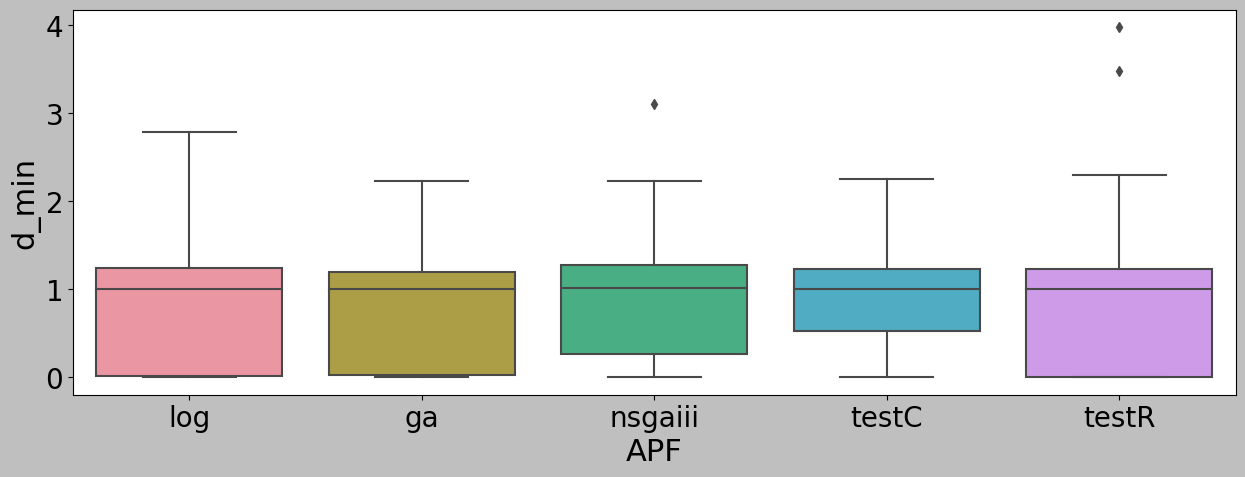

In [93]:
fname = 'Rastrigin'
tmp = df.query('target==@fname').drop(columns=['target'])
_ = sns.boxplot(x='APF', y='d_min', data=tmp)

In [94]:
from scipy.stats import ttest_ind

baseline_category = 'log'
baseline_values = tmp[tmp['APF'] == baseline_category]['min_score']

results = {}

# Perform the t-test for each category against the baseline
for category in tmp['APF'].unique():
    if category != baseline_category:
        category_values = tmp.query('APF==@category')['min_score']
        statistic, p_value = ttest_ind(category_values, baseline_values, alternative='less')
        results[category] = {'statistic': statistic, 'p_value': p_value}

# Create a DataFrame to display the results
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.index.name = 'Category'

# Display the results DataFrame
print(results_df.sort_values('p_value'))

          statistic   p_value
Category                     
ga        -1.197127  0.118064
testC     -0.632954  0.264626
testR     -0.158537  0.437292
nsgaiii    0.034299  0.513622


For each function, keep the best p and 0.

In [95]:
results = list()

for target in df.target.unique():
    tmp = df.query('target==@target')
    baseline_values = tmp.query('APF=="log"')['d_min']
    
    r = {'target':target}
    for apf in tmp.APF.unique():
        if apf != 'log':
            category_values = tmp.query('APF==@apf')['d_min']
            statistic, p_value = ttest_ind(category_values, baseline_values, alternative='less')
            r[f'p_value_{apf}'] = p_value
    results.append(r)

results = pd.DataFrame(results).set_index('target')
results

C:\Users\dinus\AppData\Local\Temp\ipykernel_22168\1558855087.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, p_value = ttest_ind(category_values, baseline_values, alternative='less')


,p_value_ga,p_value_testC,p_value_testR,p_value_testL,p_value_nsgaiii
target,,,,,
Sphere,0.852315,0.500000,0.839268,NaN,NaN
Bohachevsky,0.839268,NaN,0.569342,0.840073,NaN
Rosenbrock,0.668959,0.507373,NaN,0.163968,0.227108
Rastrigin,0.118064,0.264626,0.437292,NaN,0.513622
Ackley,0.839268,NaN,NaN,0.984928,NaN
Griewangk,0.142512,0.767710,NaN,0.250915,0.048106
Schwefel,0.022094,0.030346,0.016244,NaN,0.252174
Eggholder,0.008983,NaN,0.158222,0.064033,0.001836
Rana,0.000215,0.017485,NaN,0.000288,0.102236


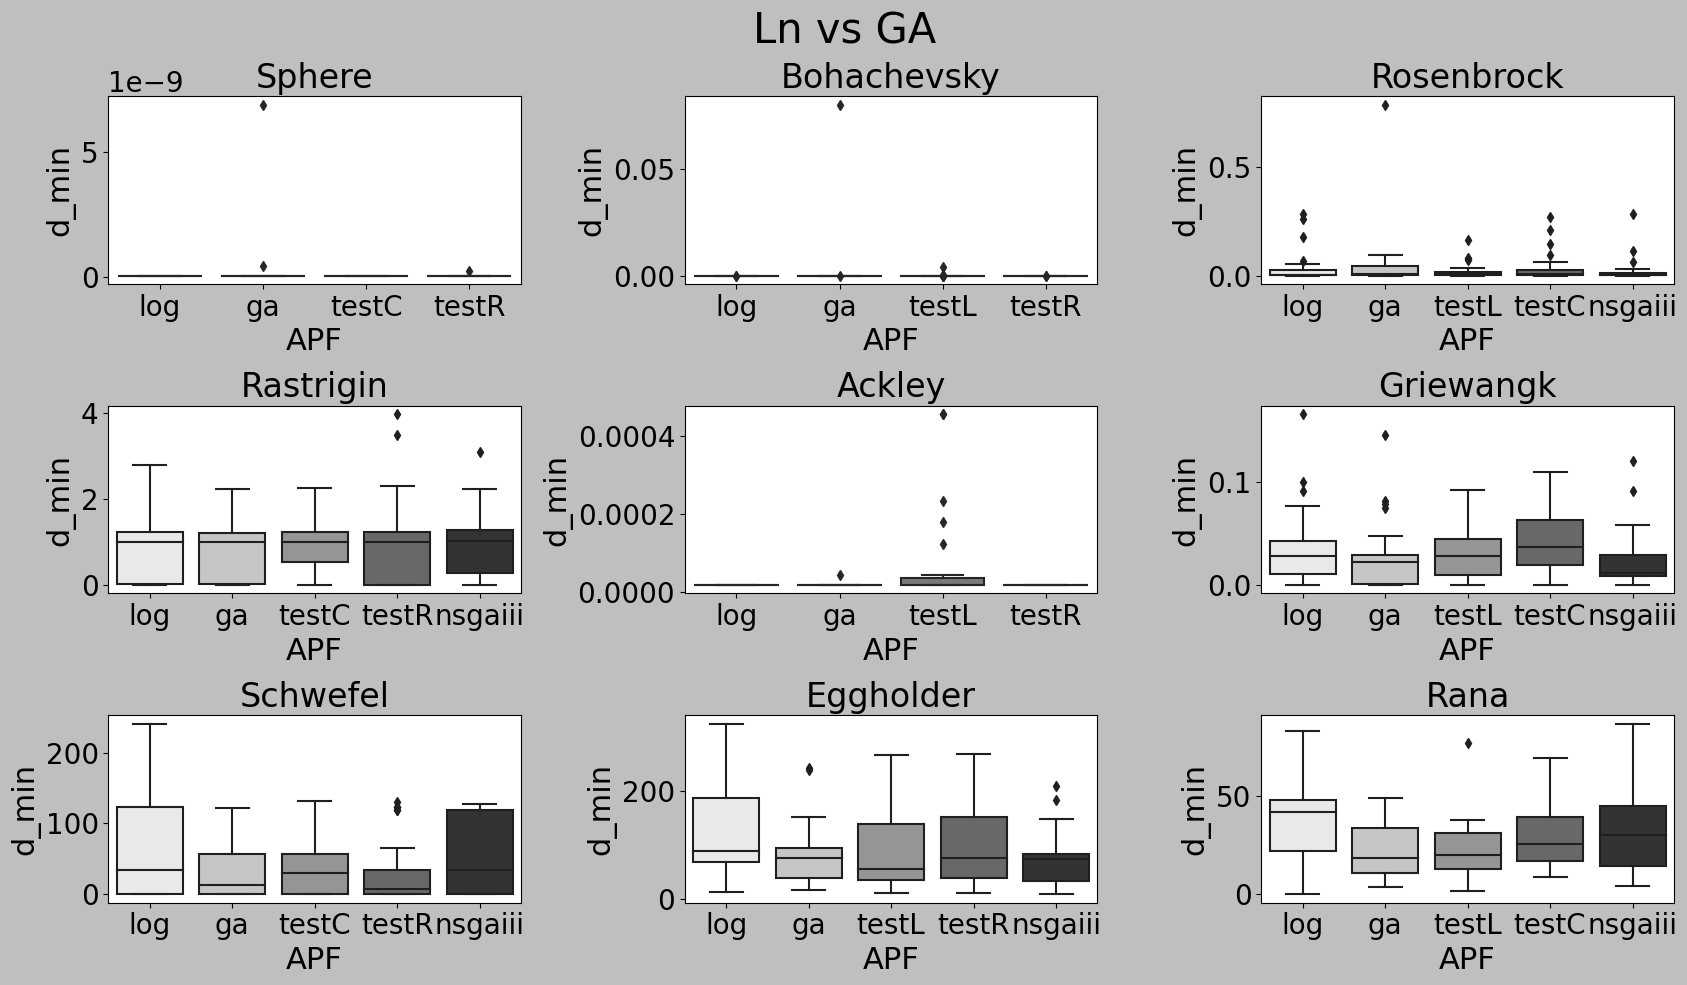

In [96]:
p = results['p_value_ga'].to_dict()

fig, ax = plt.subplots(3, 3, figsize=figsize33)
_ = plt.suptitle('Ln vs GA', fontsize=title_fontsize)
for i, target in enumerate(functions):
    _df = df[df.target==target.name].sort_values('APF', ascending=True)
    this_ax = ax[i // 3, i % 3]
    order = ['log', 'ga']
    for c in ['testL', 'testC', 'testR', 'nsgaiii']:
        if c in _df.APF.unique():
            order.append(c)
    _ = sns.boxplot(x='APF', y='d_min', data=_df, ax=this_ax, palette=('Greys'), order=order)
    _ = this_ax.set_title(f'{target.name}'); #  (p={round(p[target.name], 3)})
#         _ = this_ax.set_xticklabels(ap_names)
    _ = this_ax.set_xlabel('APF');
    _ = this_ax.set_ylabel('d_min');

fig.tight_layout()
_ = fig.savefig(plots_folder / 'exp5_Best_APFs_vs_monotonic_ln.png')
_ = fig.savefig(plots_folder / 'exp5_Best_APFs_vs_monotonic_ln.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


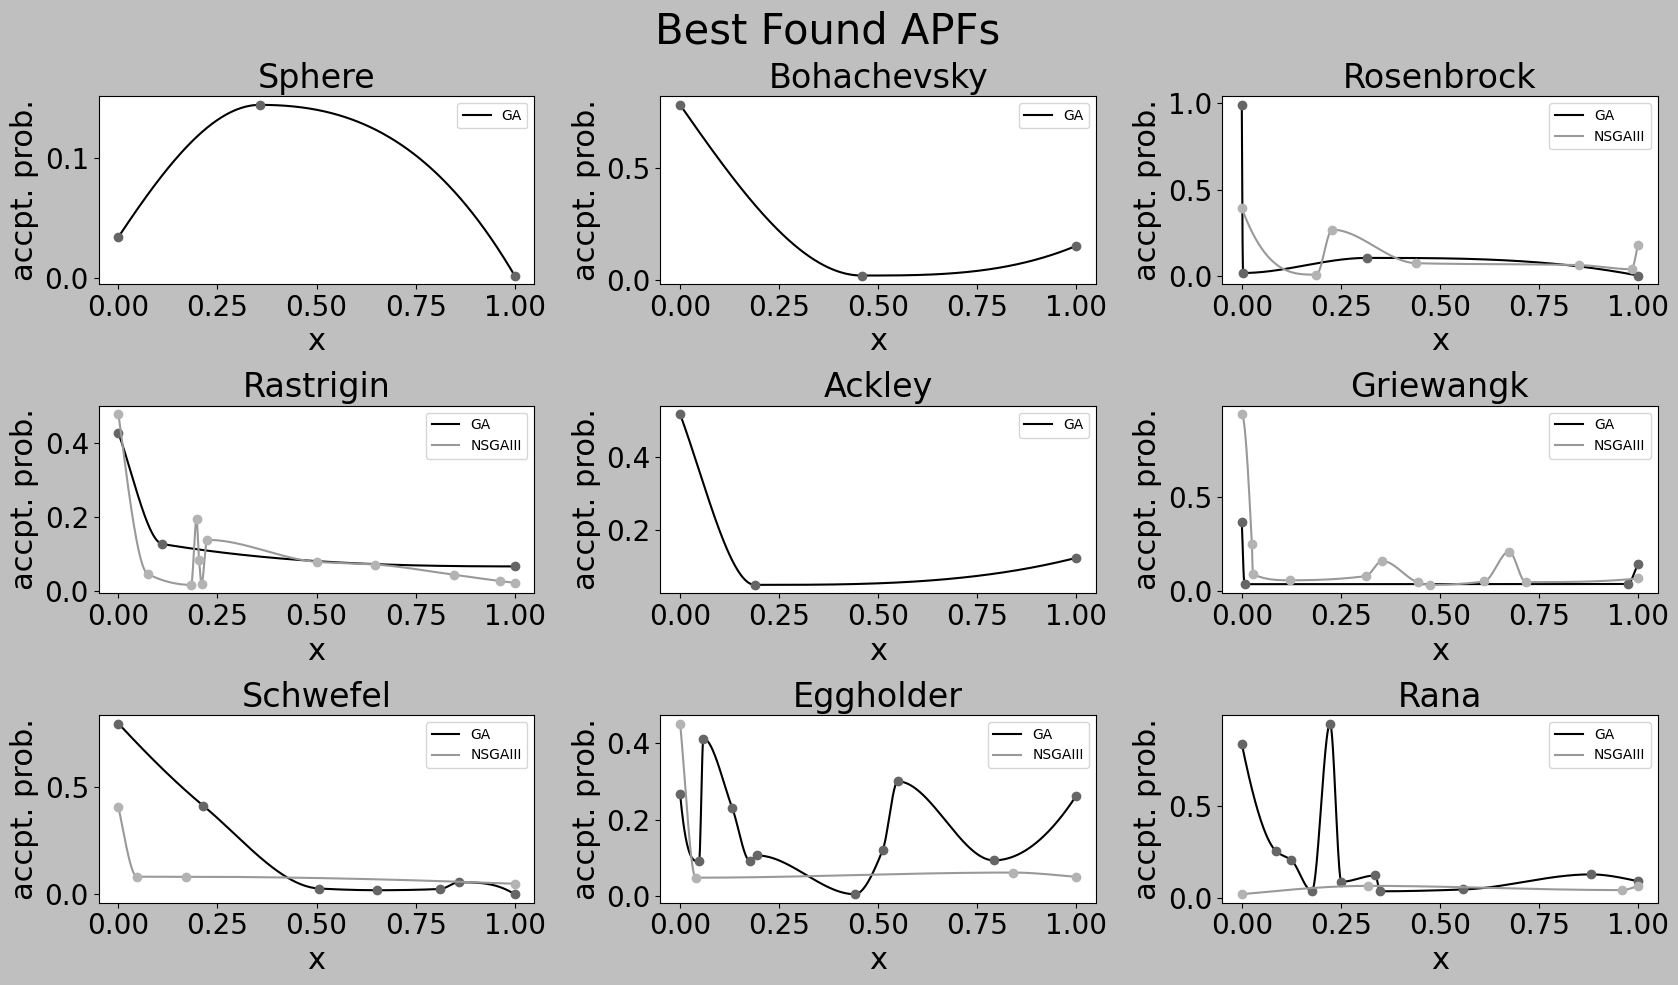

In [101]:
fig, ax = plt.subplots(3, 3, figsize=figsize33)
_ = plt.suptitle('Best Found APFs', fontsize=title_fontsize)

for i, target in enumerate(functions):
    this_ax = ax[i // 3, i % 3]
    
    x, y = ga_best_pts[target.name]
    xs, ys = ind_to_clean_points((x, y))
    newx, newy = dense_from_ind((x, y))
    _ = this_ax.plot(newx, newy, '-', label='GA')
    _ = this_ax.plot(xs, ys, 'o')
    
    try:
        x, y = mo_best_pts[target.name]
        xs, ys = ind_to_clean_points((x, y))
        newx, newy = dense_from_ind((x, y))
        _ = this_ax.plot(newx, newy, '-', label='NSGAIII')
        _ = this_ax.plot(xs, ys, 'o')
    except Exception as e:
        pass
    
    _ = this_ax.set_title(f'{target.name}'); #  (pts={len(x)}+2)
    _ = this_ax.set_xlabel('x');
    _ = this_ax.set_ylabel('accpt. prob.');
    _ = this_ax.legend()
    
fig.tight_layout()
_ = fig.savefig(plots_folder / 'exp5_Best_APFs_found.png')
_ = fig.savefig(plots_folder / 'exp5_Best_APFs_found.eps')

In [25]:
stat_results = list()

for target in df.target.unique():
    tmp = df.query('target==@target')
    if 'nsgaiii' in tmp.APF.unique():
        baseline_values = tmp.query('APF=="nsgaiii"')['d_min']

        r = {'target':target}
        for apf in tmp.APF.unique():
            if apf != 'nsgaiii':
                category_values = tmp.query('APF==@apf')['d_min']
                statistic, p_value = ttest_ind(category_values, baseline_values, alternative='less')
                r[f'p_value_{apf}'] = p_value
        stat_results.append(r)

stat_results = pd.DataFrame(stat_results).set_index('target')
stat_results

,p_value_log,p_value_ga,p_value_testL,p_value_testC,p_value_testR
target,,,,,
Rosenbrock,0.851714,0.851112,0.511526,0.881320,NaN
Rastrigin,0.982440,0.852214,NaN,0.966895,0.951692
Griewangk,0.878475,0.505238,0.720367,0.979493,NaN
Schwefel,0.823595,0.104546,NaN,0.139922,0.077519
Eggholder,0.768527,0.055360,0.211712,NaN,0.404879
Rana,0.998718,0.195382,0.223117,0.853363,NaN
